In [1]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder


In [2]:
df = pd.read_csv('final_data.csv')

In [3]:
# Define features and target variable
X = df.drop('label', axis=1)
y = df['label']

# Apply SMOTE for handling class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

In [4]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [5]:
# Define evaluation set
eval_set = [(X_train, y_train_encoded), (X_test, y_test_encoded)]

In [7]:
# Train an XGBoost classifier with multi-class configuration
xgb_model = XGBClassifier(
    random_state=42,
    objective="multi:softprob",  # Use softprob for probabilities, softmax for direct class predictions
    num_class=len(label_encoder.classes_),  # Number of unique classes
    eval_metric="mlogloss"  # Multi-class log loss
)

# Train the model with the evaluation set
xgb_model.fit(X_train, y_train_encoded, eval_set=eval_set, verbose=True)

[0]	validation_0-mlogloss:1.03903	validation_1-mlogloss:1.04025
[1]	validation_0-mlogloss:0.76899	validation_1-mlogloss:0.77047
[2]	validation_0-mlogloss:0.60048	validation_1-mlogloss:0.60208
[3]	validation_0-mlogloss:0.48804	validation_1-mlogloss:0.48976
[4]	validation_0-mlogloss:0.40415	validation_1-mlogloss:0.40584
[5]	validation_0-mlogloss:0.34567	validation_1-mlogloss:0.34740
[6]	validation_0-mlogloss:0.30036	validation_1-mlogloss:0.30220
[7]	validation_0-mlogloss:0.26705	validation_1-mlogloss:0.26889
[8]	validation_0-mlogloss:0.24263	validation_1-mlogloss:0.24444
[9]	validation_0-mlogloss:0.22193	validation_1-mlogloss:0.22379
[10]	validation_0-mlogloss:0.20792	validation_1-mlogloss:0.20981
[11]	validation_0-mlogloss:0.19649	validation_1-mlogloss:0.19844
[12]	validation_0-mlogloss:0.18670	validation_1-mlogloss:0.18882
[13]	validation_0-mlogloss:0.17988	validation_1-mlogloss:0.18199
[14]	validation_0-mlogloss:0.17338	validation_1-mlogloss:0.17552
[15]	validation_0-mlogloss:0.16911	

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=5, num_parallel_tree=None, ...)

In [8]:
# Make predictions
y_pred = xgb_model.predict(X_test)
# Decode numerical predictions back to original string labels
y_pred_decoded = label_encoder.inverse_transform(y_pred)

In [9]:
# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred_decoded))
print("Accuracy Score:", accuracy_score(y_test, y_pred_decoded))

Classification Report:
                            precision    recall  f1-score   support

                   Benign       0.94      0.93      0.93     19110
                      C&C       0.95      0.90      0.93     19376
                      DoS       0.97      0.97      0.97     19100
             FileDownload       1.00      1.00      1.00     18955
PartOfAHorizontalPortScan       0.89      0.93      0.91     19086

                 accuracy                           0.95     95627
                macro avg       0.95      0.95      0.95     95627
             weighted avg       0.95      0.95      0.95     95627

Accuracy Score: 0.9485814675771487


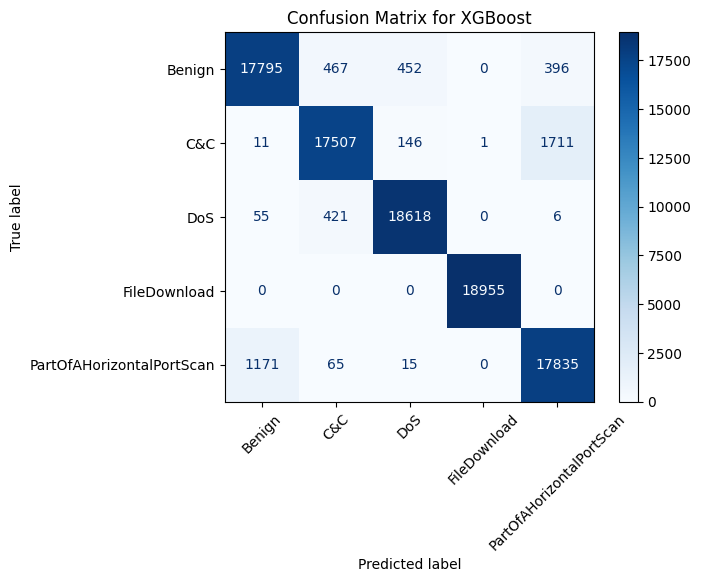

Classification Report:
                            precision    recall  f1-score   support

                   Benign     0.9350    0.9312    0.9331     19110
                      C&C     0.9484    0.9035    0.9254     19376
                      DoS     0.9681    0.9748    0.9714     19100
             FileDownload     0.9999    1.0000    1.0000     18955
PartOfAHorizontalPortScan     0.8941    0.9345    0.9138     19086

                 accuracy                         0.9486     95627
                macro avg     0.9491    0.9488    0.9487     95627
             weighted avg     0.9490    0.9486    0.9486     95627



In [10]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_decoded)

# Display confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', values_format='d', xticks_rotation=45)
plt.title("Confusion Matrix for XGBoost")
plt.show()

# Generate a classification report with detailed metrics
report = classification_report(y_test, y_pred_decoded, target_names=label_encoder.classes_, digits=4)
print("Classification Report:\n", report)

In [11]:
import joblib

# Save the trained model to a file
joblib.dump(xgb_model, 'xgb_model.pkl')


['xgb_model.pkl']

In [12]:
# Save the model using XGBoost's save_model method
xgb_model.save_model('xgb_model.json')
